In [1]:
import pandas as pd
import sys

sys.path.append("../")


In [54]:
from datetime import datetime

df = pd.read_csv("../data/casestudy_data.csv")
df["date_time"] = df["date_time"].apply(
    lambda x: datetime.strptime(x, "%m/%d/%y %H:%M")
)
df.head(3)


,visit_id,date_time,experience,success,zipcode,pro,repeat_visit,days_since_last_visit,new_movers,year_home_built,home_market_value,length_of_residence,net_worth,income,mkt_organic_product_purchasers_value,mkt_trend_env_focused_hh_value,high_end_shoppers_value,do_it_yourselfer_value,montrd_home_security_sys_own_value,mkt_green_product_purchasers_value
0,14167,2019-05-31 10:36:00,version1,0,30080,0,0,NaN,0,1987.0,320.0,8.0,250000.0,100000.0,29.0,25.0,25.0,55.0,28.0,39.0
1,195581,2019-05-31 10:37:00,version1,0,32081,1,0,NaN,0,2006.0,366.0,4.0,250000.0,125000.0,40.0,28.0,23.0,60.0,18.0,46.0
2,451142,2019-05-31 10:37:00,version2,0,91124,0,0,NaN,0,1988.0,504.0,13.0,500000.0,125000.0,21.0,12.0,16.0,76.0,32.0,31.0


In [55]:
df.columns


Index(['visit_id', 'date_time', 'experience', 'success', 'zipcode', 'pro',
       'repeat_visit', 'days_since_last_visit', 'new_movers',
       'year_home_built', 'home_market_value', 'length_of_residence',
       'net_worth', 'income', 'mkt_organic_product_purchasers_value',
       'mkt_trend_env_focused_hh_value', 'high_end_shoppers_value',
       'do_it_yourselfer_value', 'montrd_home_security_sys_own_value',
       'mkt_green_product_purchasers_value'],
      dtype='object')

In [56]:
df["version1_took"] = df.experience.apply(func=lambda x: int(x == "version1"))
df["version2_took"] = df.experience.apply(func=lambda x: int(x == "version2"))

df["version1_succeed"] = df.apply(
    func=(lambda row: int(row.experience == "version1" and row.success == 1)), axis=1
)
df["version2_succeed"] = df.apply(
    func=(lambda row: int(row.experience == "version2" and row.success == 1)), axis=1
)


In [ ]:
df_mab = df[
    [
        "date_time",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab = df_mab.set_index("date_time").sort_index()
df_mab = df_mab.cumsum()
df_mab["version1_value"] = df_mab["version1_succeed"] / df_mab["version1_took"]
df_mab["version2_value"] = df_mab["version2_succeed"] / df_mab["version2_took"]
df_mab[["version1_took", "version2_took"]].plot()
df_mab[["version1_succeed", "version2_succeed"]].plot()
df_mab[["version1_value", "version2_value"]].plot()



: 

In [ ]:
df_mab_daily = df[
    [
        "date_time",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab_daily["date_time"] = df_mab_daily["date_time"].dt.floor('d')
df_mab_daily = df_mab_daily.groupby("date_time", as_index=True).agg("sum")
df_mab_daily = df_mab_daily.sort_index().cumsum()
df_mab_daily["version1_value"] = (
    df_mab_daily["version1_succeed"] / df_mab_daily["version1_took"]
)
df_mab_daily["version2_value"] = (
    df_mab_daily["version2_succeed"] / df_mab_daily["version2_took"]
)

df_mab_daily[["version1_took", "version2_took"]].plot()
df_mab_daily[["version1_succeed", "version2_succeed"]].plot()
df_mab_daily[["version1_value", "version2_value"]].plot()


<AxesSubplot: xlabel='date_time'>

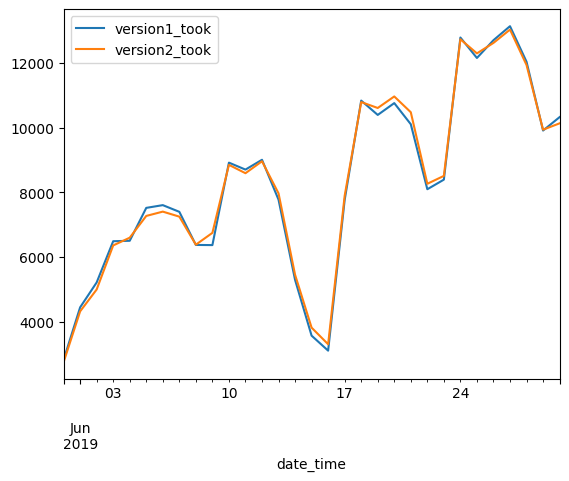

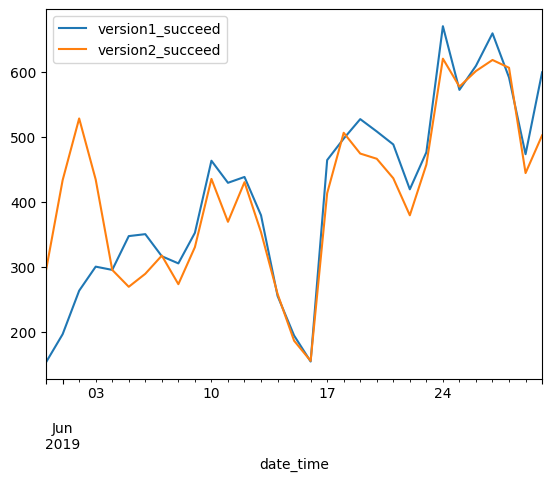

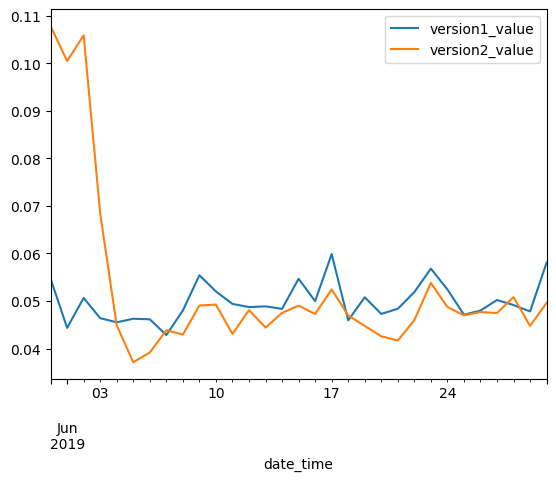

In [88]:
df_mab_daily = df[
    [
        "date_time",
        "version1_took",
        "version2_took",
        "version1_succeed",
        "version2_succeed",
    ]
].copy()

df_mab_daily["date_time"] = df_mab_daily["date_time"].dt.floor('d')
df_mab_daily = df_mab_daily.groupby("date_time", as_index=True).agg("sum")
df_mab_daily = df_mab_daily.sort_index()#.cumsum()
df_mab_daily["version1_value"] = (
    df_mab_daily["version1_succeed"] / df_mab_daily["version1_took"]
)
df_mab_daily["version2_value"] = (
    df_mab_daily["version2_succeed"] / df_mab_daily["version2_took"]
)

df_mab_daily[["version1_took", "version2_took"]].plot()
df_mab_daily[["version1_succeed", "version2_succeed"]].plot()
df_mab_daily[["version1_value", "version2_value"]].plot()
